In [50]:
import os
import numpy as np

class DistributionLoader:
    def __init__(self, folder_path):
        # Initialize with the folder path
        self.folder_path = folder_path
        self.files = self._load_files()

    def _load_files(self):
        """
        Load all `.npy` files from the folder and store the filenames and densities.
        """
        files = []
        # List all files in the folder
        for filename in os.listdir(self.folder_path):
            if filename.endswith('.npy'):
                # Extract the density value from the filename
                parts = filename.split('_')
                if len(parts) > 2:
                    density = float(parts[2].split('.npy')[0])
                    files.append((filename, density))
        return files

    def list_files(self):
        """
        Return the list of filenames in the folder.
        """
        return [filename for filename, _ in self.files]

    def filter_by_density(self, min_density, max_density):
        """
        Return a new DistributionLoader instance with only files having density between `min_density` and `max_density`.
        """
        filtered_files = [
            (filename, density) for filename, density in self.files if min_density <= density <= max_density
        ]
        # Create a new DistributionLoader instance with the filtered files
        filtered_loader = DistributionLoader(self.folder_path)
        filtered_loader.files = filtered_files
        return filtered_loader

    def load_data(self):
        """
        Load the `.npy` data for all the files.
        """
        data = {}
        for filename, _ in self.files:
            file_path = os.path.join(self.folder_path, filename)
            data[filename] = np.load(file_path)
        return data

# Usage example
folder_path = '/idiap/user/ykaloga/Assignment_Data/all_file'

# Initialize the class with the folder path
loader = DistributionLoader(folder_path)

# List all the filenames in the folder
print("All files:", loader.list_files())
print('len:', len(loader.list_files()))
data_all = loader.load_data()

# Filter files by density between 0.2 and 0.8
filtered_loader = loader.filter_by_density(0, 1)
print("Filtered files:", filtered_loader.list_files())

# Load the data for the filtered files
data = filtered_loader.load_data()
print("Loaded data for filtered files:", data.keys())
print('len:', len(data.keys()))

All files: ['distribution_000_0.821.npy', 'distribution_001_0.238.npy', 'distribution_002_0.948.npy', 'distribution_003_0.191.npy', 'distribution_004_0.585.npy', 'distribution_005_0.755.npy', 'distribution_006_0.859.npy', 'distribution_007_0.553.npy', 'distribution_008_0.266.npy', 'distribution_009_0.384.npy', 'distribution_010_0.415.npy', 'distribution_011_0.774.npy', 'distribution_012_0.151.npy', 'distribution_013_0.204.npy', 'distribution_014_0.752.npy', 'distribution_015_0.102.npy', 'distribution_016_0.822.npy', 'distribution_017_0.050.npy', 'distribution_018_0.316.npy', 'distribution_019_0.172.npy', 'distribution_020_0.073.npy', 'distribution_021_0.223.npy', 'distribution_022_0.743.npy', 'distribution_023_0.491.npy', 'distribution_024_0.853.npy', 'distribution_025_0.156.npy', 'distribution_026_0.804.npy', 'distribution_027_0.395.npy', 'distribution_028_0.863.npy', 'distribution_029_0.299.npy', 'distribution_030_0.919.npy', 'distribution_031_0.084.npy', 'distribution_032_0.171.npy'

In [58]:
import numpy as np
def simplify_representation(grid):
    ''' 2700 x 4 -> 30x30x30 '''
    return grid[:,:3].reshape([30,30,30,3]) , grid[:,-1].reshape([30,30,30])

grid_position, grid_tag = simplify_representation(data[list(data.keys())[0]])


In [59]:
import numpy as np
from collections import deque

# First step we will compute the number of pore for each grid experiments 
def compute_pore_number(grid_position, grid_tag):
    '''compute a BFS on the grid to compute the number of pore in the grid
       every adjacent location of the grid with tag = 1 belong to the same pore 
       grid_position : 30x30x30x3 (x,y,z)
       grid_tag : 30x30x30  (0 or 1)

       This function consider that to tagged point belong to the same pore they should be adjacent
       Adjency doesn't include diagonal elements
    ''' 
    pore_count = 0
    visited = np.zeros_like(grid_tag, dtype=bool)
    size = grid_tag.shape[0]  # Assuming a cubic grid

    def is_valid(x, y, z):
        return 0 <= x < size and 0 <= y < size and 0 <= z < size

    def bfs(start_x, start_y, start_z):
        queue = deque([(start_x, start_y, start_z)])
        visited[start_x, start_y, start_z] = True

        while queue:
            x, y, z = queue.popleft()

            for dx, dy, dz in [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]:
                nx, ny, nz = x + dx, y + dy, z + dz
                if is_valid(nx, ny, nz) and grid_tag[nx, ny, nz] == 1 and not visited[nx, ny, nz]:
                    visited[nx, ny, nz] = True
                    queue.append((nx, ny, nz))


    for x in range(size):
        for y in range(size):
            for z in range(size):
                if grid_tag[x, y, z] == 1 and not visited[x, y, z]:
                    bfs(x, y, z)
                    pore_count += 1

    return pore_count

    

In [60]:
pore_number = compute_pore_number(grid_position, grid_tag)
pore_number

33

In [61]:
import pandas as pd
density_to_pore_number = {}
for filename, density in filtered_loader.files:
    grid_position, grid_tag = simplify_representation(data[filename])
    pore_number = compute_pore_number(grid_position, grid_tag)
    density_to_pore_number[density] = pore_number
density_to_pore_number_dtf = pd.DataFrame(density_to_pore_number.items(), columns=['density', 'pore_number'])

In [62]:
density_to_pore_number_dtf 

,density,pore_number
0,0.238,33
1,0.266,48
2,0.204,22
3,0.223,30
4,0.299,63
5,0.213,25
6,0.212,21
7,0.269,52
8,0.296,58
9,0.255,42


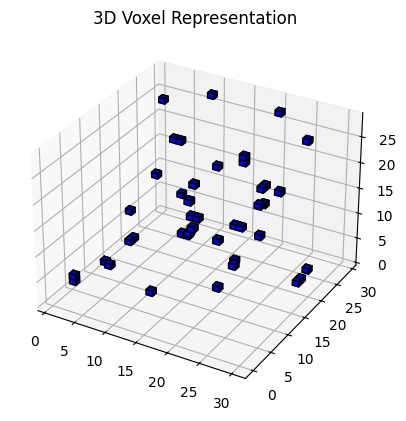

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Example 30x30x30 array (denser)
A = grid  # Creates a denser binary array


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.voxels(A, facecolors='blue', edgecolor='k')  # edgecolor='k' adds black edges
plt.title("3D Voxel Representation")
plt.show()

In [56]:
from mayavi import mlab
import numpy as np

# Example 30x30x30 array
A = grid
# Visualize with Mayavi
mlab.contour3d(A)  # Or mlab.points3d for point clouds, mlab.volume_slice for slices, etc.
mlab.show()

ModuleNotFoundError: No module named 'mayavi'

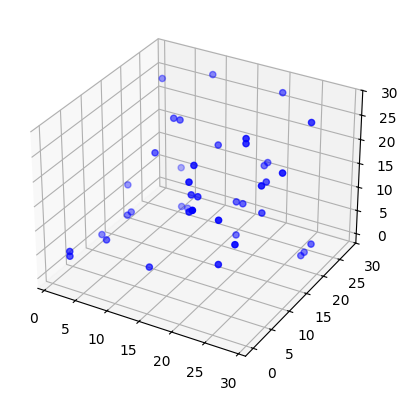

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Create a random binary 3D array (30x30x30)
A = grid
# Get coordinates where A is 1 (True points)
x, y, z = np.where(A == 1)

# Plot the points as a scatter plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')

# Show the plot
plt.show()


In [25]:
import numpy as np
from mayavi import mlab

# Create a random binary 3D array (30x30x30)
A = np.random.choice([0, 1], size=(30, 30, 30))

# Use Mayavi to render the 3D volume
mlab.figure(size=(800, 800))
mlab.contour3d(A, contours=[0.5], color=(1, 0, 0), opacity=0.5)
mlab.show()


ModuleNotFoundError: No module named 'mayavi'